## Data Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split
from geopy.distance import vincenty, geodesic

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Feb 26 12:25:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

This data preparation process is the dense and concise version described in `DataPreparation.ipynb`.

why user, trip, segement ?


is it good for time independent


is it good for the train, test, validation split


better for both CNN and RNN

`create_datesets` split the data into (user, trip, segements). Each trip contains all the segements

In [ ]:
def create_datasets_CNN():
    user = []
    label = []
    for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'):
        for ind, filename in enumerate(file):
            # sort by timestamp
            user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
            user_data_sorted = user_data[user_data[:,4].argsort()]
            #assert user_data_sorted[:,4].is_monotonic_increasing == True

            # split into trips
            trips = [] # (trip, segements, 4)
            i = 0
            for j in range(1,len(user_data_sorted)):
                if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 1200:
                    continue
                # print(np.array(user_data_sorted[i:j]))
                trips.append(user_data_sorted[i:j])
                i = j
            # print(len(trips))
            
            # split into segements for each trip
            for ind,trip in enumerate(trips):  # user -> trips -> segements
                temp_segements = []
                i = 0
                for j in range(1, len(trip)):
                    if trip[j,5] == trip[j-1,5]:
                        continue
                    temp_segements.append(trip[i:j])
                    i = j
                if(temp_segements):
                    trips[ind] = temp_segements
                else:
                    trips[ind] = [trip]
                # print("size: ",len(trips[ind]))
                # assert np.array(temp_segements).ndim == 2

            # calculate channel data
            trips_2 = []
            targets = []#np.empty((1))
            for ind,trip in enumerate(trips):
                temp_segement = []
                temp_target = []
                for ind2, segement in enumerate(trip): # segement with same mode under same trip
                    segement_4d = []

                    # drop mode 100
                    if(segement[0,5] == 100):
                        continue

                    for i in range(len(segement)-2):
                        p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                        p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                        p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                        dist = geodesic(p1, p2).meters
                        #print(dist)
                        t = segement[i+1,4] - segement[i,4]
                        if t == 0:
                            continue
                        speed = dist / t
                        acceleration = speed / t
                        jerk = acceleration / t

                        # Bearing Rate
                        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                        bearing_rate = np.abs(bearing_p2 - bearing_p1)

                        mode = segement[i,5]
                        
                        # bus
                        if mode == 0 and (speed > 34 or acceleration > 2): 
                            continue
                        # train
                        if mode == 1 and (speed > 34 or acceleration > 3): 
                            continue
                        # walk
                        if mode == 2 and (speed > 7 or acceleration > 3): 
                            continue
                        # car
                        if mode == 3 and (speed > 50 or acceleration > 10): 
                            continue
                        # bike
                        if mode == 4 and (speed > 12 or acceleration > 3): 
                            continue
                        segement_4d.append([speed, acceleration, jerk, bearing_rate])
                        
                        if len(segement_4d) % 200 == 0:                              
                            # print(np.array(segement_4d).shape)
                            temp_segement.append(segement_4d)
                            temp_target.append(segement[0,5])
                            segement_4d = []
                            # print(np.array(segement_4d).shape)
                if len(temp_segement) > 0:
                    # print( np.array(temp_segement).shape)
                    trips_2.append(temp_segement)
                    targets.append(temp_target)
            if len(trips_2) > 0:
                user.append(trips_2)
                label.append(targets)
                # print("size(segements_4d)", np.array(trips_2).shape)
                # print("size(target)", np.array(targets).shape)
    return user, label
        


`create_datesets_RNN` split the trip every seq_size segements



In [ ]:

def create_datasets_RNN(seq_size):
    user = []
    label = []
    for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'):
        for ind, filename in enumerate(file):
            # sort by timestamp
            user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
            user_data_sorted = user_data[user_data[:,4].argsort()]
            #assert user_data_sorted[:,4].is_monotonic_increasing == True

            # split into trips
            trips = [] # (trip, segements, 4)
            i = 0
            for j in range(1,len(user_data_sorted)):
                if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 1200:
                    continue
                # print(np.array(user_data_sorted[i:j]))
                trips.append(user_data_sorted[i:j])
                i = j
            # print(len(trips))
            
            # split into segements for each trip
            for ind,trip in enumerate(trips):  # user -> trips -> segements
                temp_segements = []
                i = 0
                for j in range(1, len(trip)):
                    if trip[j,5] == trip[j-1,5]:
                        continue
                    temp_segements.append(trip[i:j])
                    i = j
                if(temp_segements):
                    trips[ind] = temp_segements
                else:
                    trips[ind] = [trip]
                # print("size: ",len(trips[ind]))
                # assert np.array(temp_segements).ndim == 2

            # calculate channel data
            trips_2 = []
            targets = []#np.empty((1))
            for ind,trip in enumerate(trips):
                temp_segement = []
                temp_target = []
                for ind2, segement in enumerate(trip): # segement with same mode under same trip
                    segement_4d = []

                    # drop mode 100
                    if(segement[0,5] == 100):
                        continue

                    for i in range(len(segement)-2):
                        p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                        p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                        p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                        dist = geodesic(p1, p2).meters
                        #print(dist)
                        t = segement[i+1,4] - segement[i,4]
                        if t == 0:
                            continue
                        speed = dist / t
                        acceleration = speed / t
                        jerk = acceleration / t

                        # Bearing Rate
                        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                        bearing_rate = np.abs(bearing_p2 - bearing_p1)

                        mode = segement[i,5]
                        
                        # bus
                        if mode == 0 and (speed > 34 or acceleration > 2): 
                            continue
                        # train
                        if mode == 1 and (speed > 34 or acceleration > 3): 
                            continue
                        # walk
                        if mode == 2 and (speed > 7 or acceleration > 3): 
                            continue
                        # car
                        if mode == 3 and (speed > 50 or acceleration > 10): 
                            continue
                        # bike
                        if mode == 4 and (speed > 12 or acceleration > 3): 
                            continue
                        segement_4d.append([speed, acceleration, jerk, bearing_rate])
                        
                        if len(segement_4d) % 200 == 0:                               # from 200 -> 50
                            # print(np.array(segement_4d).shape)
                            temp_segement.append(segement_4d)
                            temp_target.append(segement[0,5])
                            segement_4d = []
                            # print(np.array(segement_4d).shape)
                        if len(temp_segement) >= seq_size:
                            # print( np.array(temp_segement).shape)
                            trips_2.append(temp_segement)
                            targets.append(temp_target)
                            temp_segement = []
                            temp_target = []
            #if len(trips_2) > 0:
                user.append(trips_2)
                label.append(targets)
                # print("size(trips)", np.array(trips_2).shape)
                # print("size(target)", np.array(targets).shape)
            else:
                print("-1")
    return user, label
        


In [ ]:
userCNN, labelCNN = create_datasets_CNN()

In [ ]:
userRNN4, labelRNN4 = create_datasets_RNN(seq_size = 4)

In [ ]:
userRNN6, labelRNN6 = create_datasets_RNN(seq_size = 6)

In [ ]:
userRNN8, labelRNN8 = create_datasets_RNN(seq_size = 8)

In [ ]:
userRNN10, labelRNN10 = create_datasets_RNN(seq_size = 10)

In [ ]:
userRNN12, labelRNN12 = create_datasets_RNN(seq_size = 12)

In [ ]:
# # dump CNN dataset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userCNN.pickle', 'wb')
pickle.dump(userCNN, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelCNN.pickle", "wb")
pickle.dump(labelCNN, l)



In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN4.pickle', 'wb')
pickle.dump(userRNN4, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN4.pickle", "wb")
pickle.dump(labelRNN4, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN6.pickle', 'wb')
pickle.dump(userRNN6, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN6.pickle", "wb")
pickle.dump(labelRNN6, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN8.pickle', 'wb')
pickle.dump(userRNN8, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN8.pickle", "wb")
pickle.dump(labelRNN8, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN10.pickle', 'wb')
pickle.dump(userRNN10, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN10.pickle", "wb")
pickle.dump(labelRNN10, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN12.pickle', 'wb')
pickle.dump(userRNN12, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN12.pickle", "wb")
pickle.dump(labelRNN12, l)

In [ ]:
# Restore CNN
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userCNN.pickle', 'rb')
userCNN = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelCNN.pickle', 'rb')
labelCNN = pickle.load(l)

# Restore RNN4
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN4.pickle', 'rb')
userRNN4 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN4.pickle', 'rb')
labelRNN4 = pickle.load(l)

# Restore RNN6
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN6.pickle', 'rb')
userRNN6 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN6.pickle', 'rb')
labelRNN6 = pickle.load(l)

# Restore RNN8
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN8.pickle', 'rb')
userRNN8 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN8.pickle', 'rb')
labelRNN8 = pickle.load(l)

# Restore RNN10
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN10.pickle', 'rb')
userRNN10 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN10.pickle', 'rb')
labelRNN10 = pickle.load(l)

# Restore RNN12
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN12.pickle', 'rb')
userRNN12 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN12.pickle', 'rb')
labelRNN12 = pickle.load(l)

In [ ]:
print('user')

print(len(userRNN4))
print(len(userRNN6))
print(len(userRNN8))
print(len(userRNN10))
print(len(userRNN12))

print('label')
print(len(labelRNN4))
print(len(labelRNN6))
print(len(labelRNN8))
print(len(labelRNN10))
print(len(labelRNN12))

user
33
29
28
28
24
label
33
29
28
28
24


0. BUS
1. Train & Subway
2. Walk & Run
3. Car & Taxi & Motocycle
4. Bike?
100. others


In [ ]:
# for i in user:
#     for j in i:
#         print(np.array(j).shape)
for i in userRNN10:
    print(np.array(i).shape)
# print(np.array(user[5]).shape)
# print(len(user[1][0]))

(11, 10, 200, 4)
(9, 10, 200, 4)
(26, 10, 200, 4)
(1, 10, 200, 4)
(162, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(25, 10, 200, 4)
(58, 10, 200, 4)
(56, 10, 200, 4)
(27, 10, 200, 4)
(26, 10, 200, 4)
(7, 10, 200, 4)
(8, 10, 200, 4)
(3, 10, 200, 4)
(9, 10, 200, 4)
(21, 10, 200, 4)
(4, 10, 200, 4)
(7, 10, 200, 4)
(35, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(2, 10, 200, 4)
(10, 10, 200, 4)
(5, 10, 200, 4)
(1, 10, 200, 4)


In [ ]:
for i in userRNN4:
    print(np.array(i).shape)

(62, 4, 200, 4)
(4, 4, 200, 4)
(1, 4, 200, 4)
(42, 4, 200, 4)
(86, 4, 200, 4)
(2, 4, 200, 4)
(10, 4, 200, 4)
(463, 4, 200, 4)
(1, 4, 200, 4)
(2, 4, 200, 4)
(2, 4, 200, 4)
(29, 4, 200, 4)
(7, 4, 200, 4)
(1, 4, 200, 4)
(185, 4, 200, 4)
(256, 4, 200, 4)
(353, 4, 200, 4)
(125, 4, 200, 4)
(162, 4, 200, 4)
(34, 4, 200, 4)
(26, 4, 200, 4)
(17, 4, 200, 4)
(61, 4, 200, 4)
(118, 4, 200, 4)
(24, 4, 200, 4)
(81, 4, 200, 4)
(180, 4, 200, 4)
(11, 4, 200, 4)
(34, 4, 200, 4)
(14, 4, 200, 4)
(125, 4, 200, 4)
(31, 4, 200, 4)
(12, 4, 200, 4)


In [ ]:
for i in userRNN6:
    print(np.array(i).shape)

(29, 6, 200, 4)
(1, 6, 200, 4)
(22, 6, 200, 4)
(49, 6, 200, 4)
(4, 6, 200, 4)
(293, 6, 200, 4)
(1, 6, 200, 4)
(1, 6, 200, 4)
(16, 6, 200, 4)
(3, 6, 200, 4)
(101, 6, 200, 4)
(133, 6, 200, 4)
(166, 6, 200, 4)
(67, 6, 200, 4)
(77, 6, 200, 4)
(17, 6, 200, 4)
(13, 6, 200, 4)
(8, 6, 200, 4)
(24, 6, 200, 4)
(68, 6, 200, 4)
(13, 6, 200, 4)
(42, 6, 200, 4)
(96, 6, 200, 4)
(2, 6, 200, 4)
(14, 6, 200, 4)
(8, 6, 200, 4)
(48, 6, 200, 4)
(13, 6, 200, 4)
(3, 6, 200, 4)


In [ ]:
for i in userRNN8:
    print(np.array(i).shape)

(18, 8, 200, 4)
(15, 8, 200, 4)
(32, 8, 200, 4)
(1, 8, 200, 4)
(204, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(41, 8, 200, 4)
(80, 8, 200, 4)
(102, 8, 200, 4)
(40, 8, 200, 4)
(46, 8, 200, 4)
(11, 8, 200, 4)
(9, 8, 200, 4)
(5, 8, 200, 4)
(16, 8, 200, 4)
(38, 8, 200, 4)
(6, 8, 200, 4)
(15, 8, 200, 4)
(59, 8, 200, 4)
(1, 8, 200, 4)
(10, 8, 200, 4)
(3, 8, 200, 4)
(24, 8, 200, 4)
(7, 8, 200, 4)
(1, 8, 200, 4)


In [ ]:
for i in userRNN12:
    print(np.array(i).shape)

(5, 12, 200, 4)
(5, 12, 200, 4)
(17, 12, 200, 4)
(1, 12, 200, 4)
(128, 12, 200, 4)
(1, 12, 200, 4)
(15, 12, 200, 4)
(40, 12, 200, 4)
(32, 12, 200, 4)
(21, 12, 200, 4)
(19, 12, 200, 4)
(7, 12, 200, 4)
(6, 12, 200, 4)
(1, 12, 200, 4)
(3, 12, 200, 4)
(13, 12, 200, 4)
(2, 12, 200, 4)
(3, 12, 200, 4)
(27, 12, 200, 4)
(1, 12, 200, 4)
(2, 12, 200, 4)
(6, 12, 200, 4)
(2, 12, 200, 4)
(1, 12, 200, 4)


In [ ]:
np.unique(labelCNN)

array([list([[0.0, 0.0]]),
       list([[0.0, 0.0], [0.0], [0.0], [2.0, 2.0], [0.0, 0.0, 0.0], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0.0], [2.0], [2.0], [0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [2.0, 2.0, 2.0, 2.0, 2.0], [3.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0, 0.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0, 2.0], [3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 0.0, 0.0, 0.0], [2.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0.0], [2.0, 2.0, 2.0], [0.0, 0.0, 0.0, 0.0], [0.0], [2.0, 2.0, 2.0, 2.0, 2.

## Visualization

In [6]:
!pip install -q holoviews
!pip install datashader

     |████████████████████████████████| 15.8MB 368kB/s 
     |████████████████████████████████| 1.6MB 52.9MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 112kB 62.5MB/s 
     |████████████████████████████████| 675kB 46.6MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=676af054df335773a6bd7aaecd91198e91cb84ddcd1feae114f6f0075e898084
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
Successfully built datashape
ERROR: distributed 2021.2.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.2.0 has requirement dask>=2021.02.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [5]:
import sys, os
data_sorted = np.empty((0, 6))
for path,directory,file in os.walk('drive/My Drive/s182190/data/Geolife/numpyL/user/'): 
    for ind, filename in enumerate(file):
        # sort by timestamp
        # sort by timestamp
        user_data = np.load('drive/My Drive/s182190/data/Geolife/numpyL/user/' + filename) # shape (row, col)
        user_data_sorted = user_data[user_data[:,4].argsort()]
        data_sorted = np.vstack((data_sorted, user_data_sorted))
print(np.array(data_sorted).shape)
print(np.unique(data_sorted[:, 5]))
data = pd.DataFrame(data_sorted, columns = ['user_id', 'latitude','longitude', 'altitude','timestamp', 'mode']).astype({'user_id':'int64', 'latitude':'float64','longitude':'float64', 'altitude':'float64','timestamp':'int64', 'mode':'int64'} )
data

(5386677, 6)
[  0.   1.   2.   3.   4. 100.]


,user_id,latitude,longitude,altitude,timestamp,mode
0,10,39.973450,116.327417,200.131234,1192022636,4
1,10,39.972817,116.327400,206.692913,1192022666,4
2,10,39.972400,116.327350,232.939633,1192022685,4
3,10,39.972200,116.327383,259.186352,1192022693,4
4,10,39.971950,116.327417,278.871391,1192022705,4
...,...,...,...,...,...,...
5386672,8,39.975308,116.330498,179.000000,1228954984,4
5386673,8,39.975303,116.330547,171.000000,1228954986,4
5386674,8,39.975300,116.330590,164.000000,1228954988,4
5386675,8,39.975286,116.330639,160.000000,1228954990,4


In [ ]:
data.head(5)

,user_id,latitude,longitude,altitude,timestamp,mode
0,10,39.973450,116.327417,200.131234,1192022636,4
1,10,39.972817,116.327400,206.692913,1192022666,4
2,10,39.972400,116.327350,232.939633,1192022685,4
3,10,39.972200,116.327383,259.186352,1192022693,4
4,10,39.971950,116.327417,278.871391,1192022705,4


In [ ]:
data.describe().apply("{0:.3f}".format)

,user_id,latitude,longitude,altitude,timestamp,mode
count,5.386677e+06,5.386677e+06,5.386677e+06,5.386677e+06,5.386677e+06,5.386677e+06
mean,3.626056e+01,3.946732e+01,1.144995e+02,5.922112e+02,1.239388e+09,2.094284e+00
std,1.927445e+01,2.383322e+00,1.522834e+01,2.416462e+03,3.616806e+07,4.962046e+00
min,1.000000e+00,1.824990e+01,-1.799696e+02,-2.304130e+04,1.176366e+09,0.000000e+00
25%,2.100000e+01,3.992277e+01,1.163094e+02,0.000000e+00,1.216523e+09,1.000000e+00
50%,3.300000e+01,3.997505e+01,1.163318e+02,1.260000e+02,1.223889e+09,2.000000e+00
75%,5.500000e+01,3.999115e+01,1.164182e+02,1.940000e+02,1.245129e+09,3.000000e+00
max,6.900000e+01,4.001667e+02,1.799969e+02,5.196190e+04,1.325341e+09,1.000000e+02


In [7]:
# show Beijing Map
x_range=[39.8, 40.1]
y_range=[116.25, 116.5]

In [8]:
import numpy as np
import holoviews as hv
from holoviews import opts
from holoviews.element.tiles import StamenTerrain
from datashader.utils import lnglat_to_meters
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9

os.environ['HV_DOC_HTML'] = 'true'

hv.extension('bokeh')

Output hidden; open in https://colab.research.google.com to view.

In [9]:
data_range = data[(data['latitude'] <= 40.1) & (data['latitude'] >=39.8)]
data_range = data_range[(data_range['longitude'] <= 116.5) & (data_range['longitude'] >=116.25)]
data_range.loc[:,'y'], data_range.loc[:,'x'] = lnglat_to_meters(data_range.longitude, data_range.latitude)

0. BUS
1. Train & Subway
2. Walk & Run
3. Car & Taxi & Motocycle
4. Bike?
100. others


In [10]:
colors = ["green","red","yellow","cyan","white","blue"]

In [11]:
import holoviews as hv
from holoviews.element import tiles
from holoviews.operation.datashader import datashade, dynspread
import holoviews.operation.datashader as hd
from colorcet import fire
hv.extension('bokeh')

url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'
tile_opts  = dict(width=1000,height=600,xaxis=None,yaxis=None,bgcolor='black',show_grid=False)
map_tiles  = tiles.EsriImagery().opts(style=dict(alpha=0.5), plot=tile_opts)
points     = hv.Points(data_range, ['y', 'x'])
# taxi_trips = datashade(points, x_sampling=1, y_sampling=1, cmap=fire, width=1000, height=600)
shade =  datashade(points,aggregator=ds.count_cat('mode'), color_key=colors)
dyn = dynspread(shade, threshold=0.3, max_px=4).opts(bgcolor='black', xaxis=None, yaxis=None, width=1000, height=600)
map_tiles *dyn

Output hidden; open in https://colab.research.google.com to view.


## Define a Convolutional Neural Network

### prepare

In [ ]:
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
#from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [ ]:
import torch
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [ ]:
input_width = 200
input_height = 4
input_channels = 1
num_classes = 5
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=32,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=32,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv3 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, 
                               out_channels=64,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv5 = nn.Conv2d(in_channels=64,
                               out_channels =128,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(p = 0.5)
        
        # self.batchnorm = nn.BatchNorm2d(10)
        
        # fully connected output layers
        self.l1_in_features = 14336
        self.fc1 = nn.Linear(in_features= self.l1_in_features, 
                             out_features=50)
        self.fc2 = nn.Linear(in_features=50,
                             out_features=num_classes)

    def forward(self, x):
        # Perform the usual forward pass
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = x.reshape(-1, self.l1_in_features)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=14336, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
)


In [ ]:
import numpy as np
net = Net()
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

1003537

### define train, validation, test sets

In [ ]:
# split to train, valid, test set
x, x_test, y, y_test = train_test_split(userCNN,labelCNN,test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.375)

# flatten and reshape to (batch, channel, width, height)
print(np.array([seg for user in x_train for trip in user for seg in trip]).shape)
x_train = np.array([seg for user in x_train for trip in user for seg in trip])[:,np.newaxis,:,:]
x_valid = np.array([seg for user in x_valid for trip in user for seg in trip])[:,np.newaxis,:,:]
x_test  = np.array([seg for user in x_test for trip in user for seg in trip])[:,np.newaxis,:,:]
print(x_train.shape, x_valid.shape, x_test.shape)
print(len(y_train), len(y_valid))

# change label encoding from float to int
y_train = np.array([seg for user in y_train for trip in user for seg in trip], dtype = int)
y_valid = np.array([seg for user in y_valid for trip in user for seg in trip], dtype = int)
y_test = np.array([seg for user in y_test for trip in user for seg in trip], dtype = int)
print(len(y_train), len(y_valid), len(y_test))

(10490, 200, 4)
(10490, 1, 200, 4) (5354, 1, 200, 4) (977, 1, 200, 4)
19 12
10490 5354 977


### Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)

criterion = nn.CrossEntropyLoss(weight=weights)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

[0 1 2 3 4] [2620 2860 2138 1888  984]
tensor([0.3756, 0.3441, 0.4602, 0.5212, 1.0000], device='cuda:0')


### Train the network

<span class="burk">discuss: is the randomization reasonable. mutiple sampling method, take average</span>

Epoch  2 : Train Loss 0.012258 , Validation Loss 0.014064, Train acc 0.403935, Valid acc 0.248666
Epoch 12 : Train Loss 0.009879 , Validation Loss 0.014575, Train acc 0.550637, Valid acc 0.394436
Epoch 22 : Train Loss 0.007975 , Validation Loss 0.020225, Train acc 0.699942, Valid acc 0.706745
Epoch 32 : Train Loss 0.006645 , Validation Loss 0.024631, Train acc 0.768711, Valid acc 0.748857
Epoch 42 : Train Loss 0.005880 , Validation Loss 0.028379, Train acc 0.815394, Valid acc 0.777630
Epoch 52 : Train Loss 0.005360 , Validation Loss 0.036767, Train acc 0.830247, Valid acc 0.755145
Epoch 62 : Train Loss 0.004673 , Validation Loss 0.042479, Train acc 0.849344, Valid acc 0.753239
Epoch 72 : Train Loss 0.004039 , Validation Loss 0.066783, Train acc 0.873843, Valid acc 0.750762
Epoch 82 : Train Loss 0.003305 , Validation Loss 0.077567, Train acc 0.908083, Valid acc 0.753239
Epoch 92 : Train Loss 0.003023 , Validation Loss 0.079390, Train acc 0.922647, Valid acc 0.746570
Epoch 102 : Train Lo

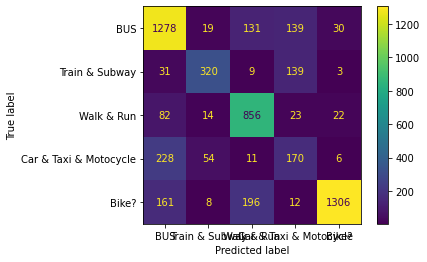

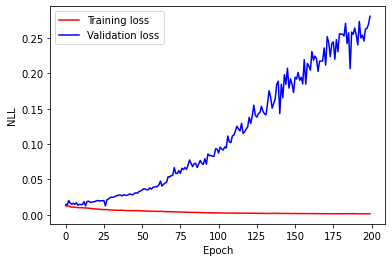

In [ ]:
batch_size = 128
num_epochs = 200
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long())
        #print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()
        loss.backward()
        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
        optimizer.step()
        
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        
        output = net(x_batch.float().cuda())
        preds = torch.max(output, 1)[1]
        # print('targets: ', y_train[slc])
        # print('preds:', preds)

        train_targs += list(y_train[slc])
        train_preds += list(preds.cpu().data.numpy())
        
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slc]))
        
        output = net(x_batch.float().cuda())

        # Compute loss
        loss = criterion(output, y_batch.cuda())
        # Update loss
        epoch_validation_loss += loss.detach().cpu().numpy()

        preds = torch.max(output, 1)[1]
        val_preds += list(preds.cpu().data.numpy())
        val_targs += list(y_valid[slc])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)

    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 1:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.3968942901234568, 0.4039351851851852, 0.4090470679012346, 0.48678626543209874, 0.5072337962962963, 0.4039351851851852, 0.5301890432098766, 0.49440586419753085, 0.5335648148148148, 0.5268132716049383, 0.447241512345679, 0.5506365740740741, 0.5022183641975309, 0.5384837962962963, 0.5834297839506173, 0.6023341049382716, 0.6282793209876543, 0.6234567901234568, 0.6381172839506173, 0.654320987654321, 0.6651234567901234, 0.6999421296296297, 0.7353395061728395, 0.7171103395061729, 0.7271412037037037, 0.7221257716049383, 0.5054976851851852, 0.7155671296296297, 0.746141975308642, 0.7605131172839507, 0.7431520061728395, 0.7687114197530864, 0.7801890432098766, 0.7903163580246914, 0.7938850308641975, 0.7853973765432098, 0.7881944444444444, 0.7911844135802469, 0.8017939814814815, 0.808545524691358, 0.8153935185185185, 0.8153935185185185, 0.8097993827160493, 0.816358024691358, 0.8206983024691358, 0.8206018518518519, 0.8259066358024691, 0.800733024691358, 0.8244598765432098, 0.8304398148148148, 0.8

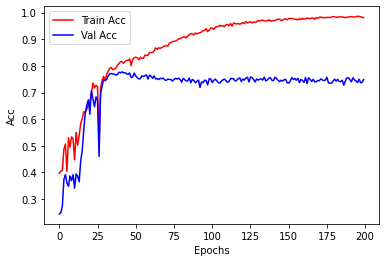


Test set Acc:  0.703173


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test), list(preds.cpu().data.numpy()))))



In [ ]:
from sklearn.metrics import confusion_matrix
print('Bus", "Train", "Walk", "Car", "Bike"')
confusion_matrix(list(y_test), list(preds.cpu().data.numpy()))

Bus", "Train", "Walk", "Car", "Bike"


array([[179,   1,   4,  24,   8],
       [ 18,  35,  17,  21,   2],
       [ 21,  10, 224,   6,  16],
       [ 40,   3,  10,  79,   2],
       [ 25,   0,  62,   0, 170]])


## Define a Convolutional Neural Network with Batch Norm

In [ ]:
input_width = 200
input_height = 4
input_channels = 1
num_classes = 5
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=32,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=32,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv3 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, 
                               out_channels=64,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv5 = nn.Conv2d(in_channels=64,
                               out_channels =128,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128,
                               stride=1,
                               kernel_size=3,
                               padding=2)
        
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(p = 0.5)
        
        self.batchnorm = nn.BatchNorm2d(1)
        
        # fully connected output layers
        self.l1_in_features = 14336
        self.fc1 = nn.Linear(in_features= self.l1_in_features, 
                             out_features=50)
        self.fc2 = nn.Linear(in_features=50,
                             out_features=num_classes)

    def forward(self, x):
        # Perform the usual forward pass
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = x.reshape(-1, self.l1_in_features)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=14336, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
)


### define train, validation, test sets

### Define a Loss function and optimizer

### Train the network

<span class="burk">discuss: is the randomization reasonable. mutiple sampling method, take average</span>

Epoch  2 : Train Loss 0.012517 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 12 : Train Loss 0.012520 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 22 : Train Loss 0.012525 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 32 : Train Loss 0.012524 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 42 : Train Loss 0.012521 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 52 : Train Loss 0.012523 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 62 : Train Loss 0.012511 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 72 : Train Loss 0.012529 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 82 : Train Loss 0.012516 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 92 : Train Loss 0.012519 , Validation Loss 0.012581, Train acc 0.290123, Valid acc 0.123666
Epoch 102 : Train Lo

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


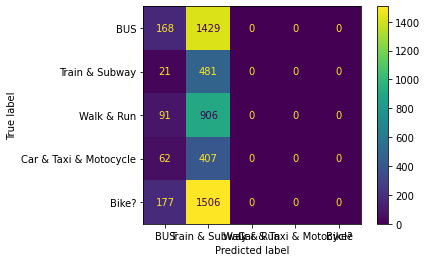

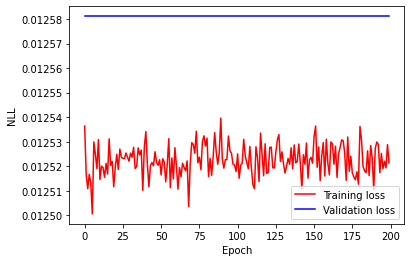

In [ ]:
batch_size = 128
num_epochs = 200
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long())
        #print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()
        loss.backward()
        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
        optimizer.step()
        
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        
        output = net(x_batch.float().cuda())
        preds = torch.max(output, 1)[1]
        # print('targets: ', y_train[slc])
        # print('preds:', preds)

        train_targs += list(y_train[slc])
        train_preds += list(preds.cpu().data.numpy())
        
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slc]))
        
        output = net(x_batch.float().cuda())

        # Compute loss
        loss = criterion(output, y_batch.cuda())
        # Update loss
        epoch_validation_loss += loss.detach().cpu().numpy()

        preds = torch.max(output, 1)[1]
        val_preds += list(preds.cpu().data.numpy())
        val_targs += list(y_valid[slc])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)

    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 1:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.29012345679012347, 0.2901234567

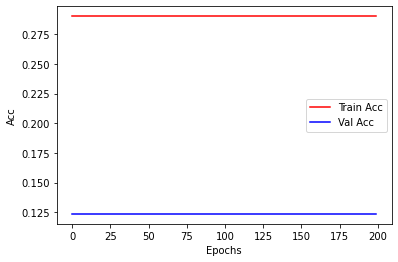


Test set Acc:  0.112590


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test), list(preds.cpu().data.numpy()))))



In [ ]:
from sklearn.metrics import confusion_matrix
print('Bus", "Train", "Walk", "Car", "Bike"')
confusion_matrix(list(y_test), list(preds.cpu().data.numpy()))

Bus", "Train", "Walk", "Car", "Bike"


array([[ 24, 192,   0,   0,   0],
       [  7,  86,   0,   0,   0],
       [ 25, 252,   0,   0,   0],
       [ 21, 113,   0,   0,   0],
       [ 24, 233,   0,   0,   0]])